In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import date, timedelta
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

C:\Users\Nylle\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Nylle\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\Nylle\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# READ IN ALL DATA
comments = pd.read_csv('comments_preprocessed_assigned.csv')
sentiment = pd.read_csv('df_pred_id_body.csv')
fin_data = pd.read_csv(r'C:\Users\Nylle\`Assignments\LSTM\Stock\PLTR_2021.csv')

In [3]:
import prediction_prep as prep

df = prep.get_regression_df(ticker_name = 'pltr', #
                           comments = comments, 
                           fin_data = fin_data,
                           sentiment = sentiment)
df.head()

,date,comments_neutral,comments_positive,comment_count,pct_pos_comments,is_meme,comments_neutral_rollsum_2D,comments_neutral_rollmean_2D,comments_neutral_2D_pctchg,comments_positive_rollsum_2D,...,Dir,2Dir,3Dir,4Dir,5Dir,6Dir,7Dir,SD,day_of_week,SD_log
0,2021-01-01,272.0,95.0,367.0,25.885552,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN
1,2021-01-02,19.0,12.0,31.0,38.709553,0,291.0,145.5,NaN,107.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN
2,2021-01-03,341.0,130.0,471.0,27.600843,0,360.0,180.0,25.367647,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN
3,2021-01-04,239.0,67.0,306.0,21.895418,0,580.0,290.0,1157.894737,197.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.316741,0,0.275160
4,2021-01-05,59.0,57.0,116.0,49.137889,0,298.0,149.0,-82.697947,124.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.516378,1,-0.660916


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 0 to 365
Data columns (total 100 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   date                           366 non-null    datetime64[ns]
 1   comments_neutral               366 non-null    float64       
 2   comments_positive              366 non-null    float64       
 3   comment_count                  366 non-null    float64       
 4   pct_pos_comments               366 non-null    float64       
 5   is_meme                        366 non-null    int32         
 6   comments_neutral_rollsum_2D    365 non-null    float64       
 7   comments_neutral_rollmean_2D   365 non-null    float64       
 8   comments_neutral_2D_pctchg     321 non-null    float64       
 9   comments_positive_rollsum_2D   365 non-null    float64       
 10  comments_positive_rollmean_2D  365 non-null    float64       
 11  comments_positive_

## LSTM: PLTR Close Price

### Without Normalization

In [5]:
## DAILY%CHANGE ##
dep_var = ['Close'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)
pred_lag = pred_lag[['Close', 'day_of_week','Daily%Change(t-1)','3Dir(t-1)', 'Volume(t-1)', 'Dir(t-1)', 
                     'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)', '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
                     '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)','7Dir(t-1)', '6Dir(t-1)', 
                     '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)', 'Close(t-1)']]
pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['Volume', 'Open', 'Dir', '5Dir', '5D%Change', '6D%Change', '4Dir', '7Dir', '2Dir', '3D%Change', 'SD_log', 'Low', 'High', '2D%Change', '6Dir', '4D%Change', 'SD', 'Daily%Change', '7D%Change', '3Dir']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,2D%Change(t-1),SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1)
7,25.500000,2,0.964134,1.0,26887200.0,1.0,26.340000,11.214950,25.510000,11.167733,...,3.888887,0.043892,1.0,4.720001,1.0,1.0,6.422764,1.044869,12.023960,26.180000
8,24.920000,3,-2.597404,1.0,51216600.0,0.0,25.709999,2.000000,25.129999,9.114245,...,-1.658312,0.516771,1.0,1.190473,1.0,1.0,8.326249,1.676605,3.658535,25.500000
9,25.639999,4,-2.274510,0.0,32908000.0,0.0,25.450001,-1.111114,24.370001,1.300812,...,-4.812835,0.075967,0.0,-3.895103,1.0,1.0,-0.320000,1.078927,5.862358,24.920000
10,26.620001,1,2.889243,0.0,92285500.0,1.0,26.260000,-1.118399,25.459999,8.920979,...,0.549017,1.423364,0.0,-2.062647,1.0,1.0,1.746026,4.151063,2.559998,25.639999
11,26.340000,2,3.822159,1.0,48675800.0,1.0,26.809999,1.680674,26.000000,6.480003,...,6.821833,0.896991,1.0,4.392160,1.0,1.0,2.661012,2.452214,5.634921,26.620001


In [6]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'day_of_week', 'Daily%Change(t-1)', '3Dir(t-1)', 'Volume(t-1)', 'Dir(t-1)', 'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)', '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)', '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)', '7Dir(t-1)', '6Dir(t-1)', '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)', 'Close(t-1)']


,Close,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1),Prediction
245,18.879999,2,5.233856,1.0,33878600.0,1.0,18.160000,0.212084,18.100000,-0.211198,...,0.142083,1.0,3.053432,0.0,1.0,1.394851,1.152673,2.717391,18.900000,18.879999
246,18.930000,3,-0.105823,0.0,33894200.0,0.0,18.650000,2.944378,18.650000,2.608693,...,-0.584788,1.0,-0.944388,1.0,1.0,0.106037,0.557224,1.287552,18.879999,18.930000
247,18.940001,0,0.264837,1.0,24758300.0,1.0,18.850000,-0.682052,18.719999,1.555799,...,-0.491682,0.0,5.400898,1.0,1.0,3.217013,0.611597,0.371154,18.930000,18.940001
248,18.570000,1,0.052827,1.0,21782000.0,1.0,18.780001,5.456579,18.780001,0.424178,...,-0.460671,1.0,0.211645,1.0,1.0,-0.629585,0.630860,3.271540,18.940001,18.570000
249,18.170000,2,-1.953542,0.0,20518800.0,0.0,18.889999,-1.746031,18.440001,1.254087,...,-0.352068,0.0,-1.641946,1.0,0.0,3.396440,0.703232,-2.570828,18.570000,18.170000


In [7]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc("Close")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len]
test_data = data_filtered.iloc[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)


# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'][0:train_data_len])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(195, 23)
(55, 23)


In [8]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(188, 7, 23) (188,)
(48, 7, 23) (48,)
0.8657294924649557
0.8657294924649557


In [9]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

161 7 23


In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = 'PLTR_woSentiment_ClosePrice_woNormalization.h5'
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
12/12 [==============================] - ETA: 0s - loss: 0.0266
Epoch 1: val_loss improved from inf to 0.00835, saving model to PLTR_woSentiment_ClosePrice_woNormalization.h5
12/12 [==============================] - 5s 85ms/step - loss: 0.0266 - val_loss: 0.0084
Epoch 2/100
 9/12 [=====================>........] - ETA: 0s - loss: 0.0129
Epoch 2: val_loss improved from 0.00835 to 0.00249, saving model to PLTR_woSentiment_ClosePrice_woNormalization.h5
12/12 [==============================] - 0s 25ms/step - loss: 0.0110 - val_loss: 0.0025
Epoch 3/100
 9/12 [=====================>........] - ETA: 0s - loss: 0.0099
Epoch 3: val_loss did not improve from 0.00249
12/12 [==============================] - 0s 20ms/step - loss: 0.0099 - val_loss: 0.0036
Epoch 4/100
 9/12 [=====================>........] - ETA: 0s - loss: 0.0077
Epoch 4: val_loss did not improve from 0.00249
12/12 [==============================] - 0s 20ms/step - loss: 0.0080 - val_loss: 0.0028
Epoch 5/100
 9/12 [=====

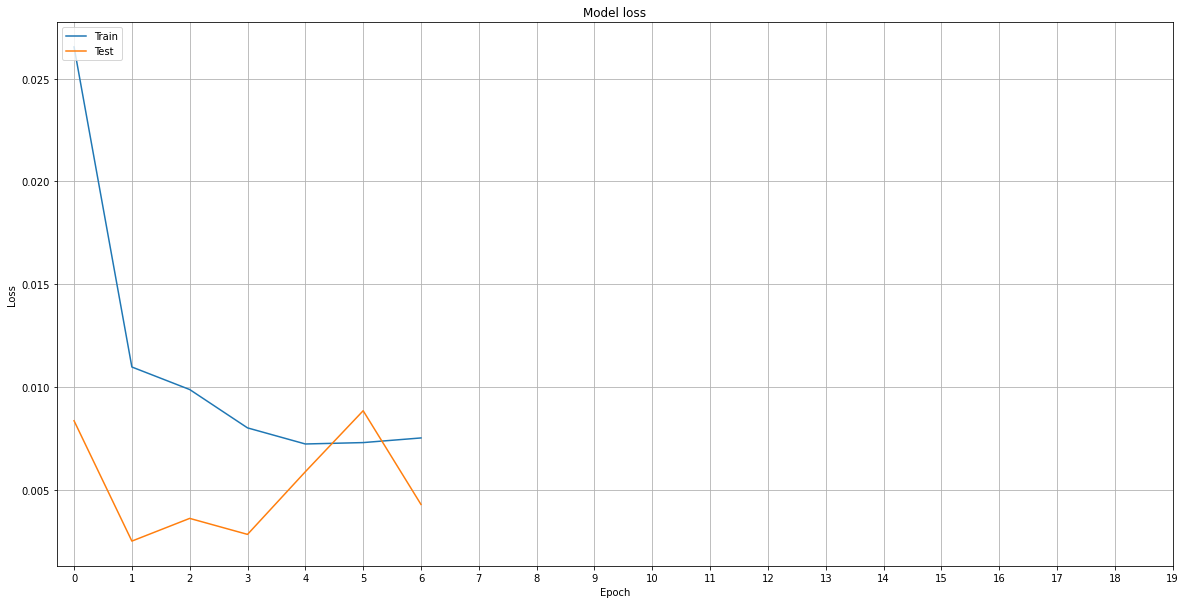

In [11]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"]) 
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(20))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [12]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])
results

Median Absolute Error (MAE): 0.85
Mean Absolute Percentage Error (MAPE): 3.77 %
Median Absolute Percentage Error (MDAPE): 3.6 %


,MAE,MAPE,MDAPE
0,0.846583,3.768758,3.599588


In [13]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)
valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

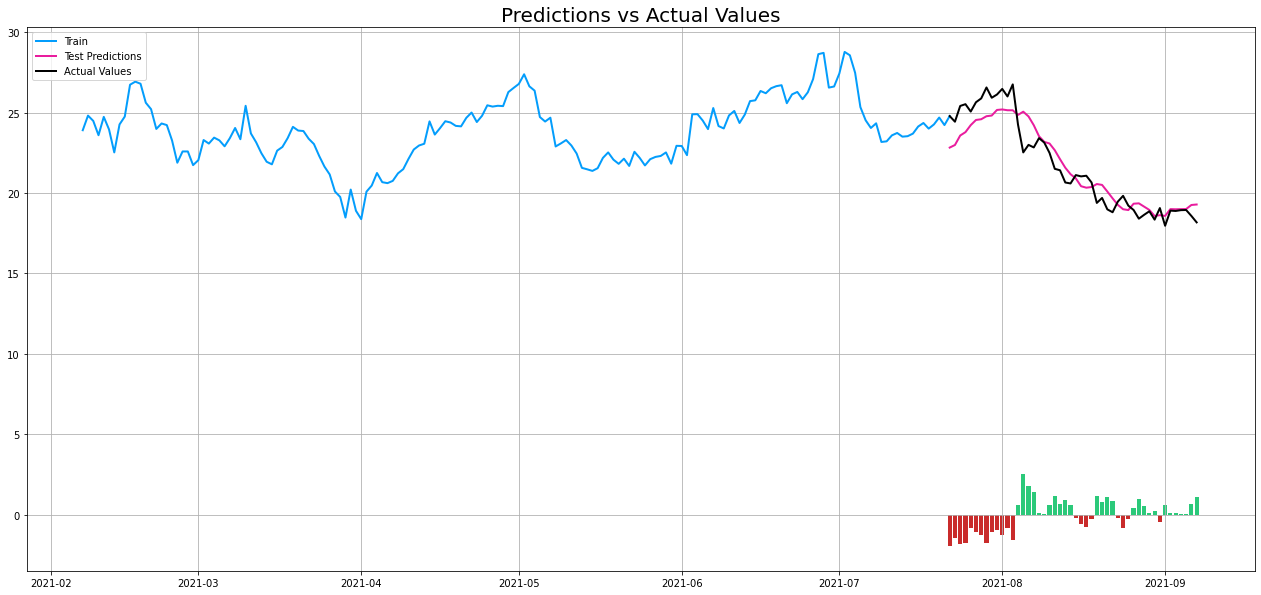

In [14]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

### Normalization

In [15]:
## DAILY%CHANGE ##
dep_var = ['Close'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)
pred_lag = pred_lag[['Close', 'day_of_week','Daily%Change(t-1)','3Dir(t-1)', 'Volume(t-1)', 'Dir(t-1)', 
                     'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)', '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
                     '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)','7Dir(t-1)', '6Dir(t-1)', 
                     '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)', 'Close(t-1)']]
pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['Volume', 'Open', 'Dir', '5Dir', '5D%Change', '6D%Change', '4Dir', '7Dir', '2Dir', '3D%Change', 'SD_log', 'Low', 'High', '2D%Change', '6Dir', '4D%Change', 'SD', 'Daily%Change', '7D%Change', '3Dir']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,2D%Change(t-1),SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1)
7,25.500000,2,0.964134,1.0,26887200.0,1.0,26.340000,11.214950,25.510000,11.167733,...,3.888887,0.043892,1.0,4.720001,1.0,1.0,6.422764,1.044869,12.023960,26.180000
8,24.920000,3,-2.597404,1.0,51216600.0,0.0,25.709999,2.000000,25.129999,9.114245,...,-1.658312,0.516771,1.0,1.190473,1.0,1.0,8.326249,1.676605,3.658535,25.500000
9,25.639999,4,-2.274510,0.0,32908000.0,0.0,25.450001,-1.111114,24.370001,1.300812,...,-4.812835,0.075967,0.0,-3.895103,1.0,1.0,-0.320000,1.078927,5.862358,24.920000
10,26.620001,1,2.889243,0.0,92285500.0,1.0,26.260000,-1.118399,25.459999,8.920979,...,0.549017,1.423364,0.0,-2.062647,1.0,1.0,1.746026,4.151063,2.559998,25.639999
11,26.340000,2,3.822159,1.0,48675800.0,1.0,26.809999,1.680674,26.000000,6.480003,...,6.821833,0.896991,1.0,4.392160,1.0,1.0,2.661012,2.452214,5.634921,26.620001


In [16]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'day_of_week', 'Daily%Change(t-1)', '3Dir(t-1)', 'Volume(t-1)', 'Dir(t-1)', 'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)', '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)', '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)', '7Dir(t-1)', '6Dir(t-1)', '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)', 'Close(t-1)']


,Close,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1),Prediction
245,18.879999,2,5.233856,1.0,33878600.0,1.0,18.160000,0.212084,18.100000,-0.211198,...,0.142083,1.0,3.053432,0.0,1.0,1.394851,1.152673,2.717391,18.900000,18.879999
246,18.930000,3,-0.105823,0.0,33894200.0,0.0,18.650000,2.944378,18.650000,2.608693,...,-0.584788,1.0,-0.944388,1.0,1.0,0.106037,0.557224,1.287552,18.879999,18.930000
247,18.940001,0,0.264837,1.0,24758300.0,1.0,18.850000,-0.682052,18.719999,1.555799,...,-0.491682,0.0,5.400898,1.0,1.0,3.217013,0.611597,0.371154,18.930000,18.940001
248,18.570000,1,0.052827,1.0,21782000.0,1.0,18.780001,5.456579,18.780001,0.424178,...,-0.460671,1.0,0.211645,1.0,1.0,-0.629585,0.630860,3.271540,18.940001,18.570000
249,18.170000,2,-1.953542,0.0,20518800.0,0.0,18.889999,-1.746031,18.440001,1.254087,...,-0.352068,0.0,-1.641946,1.0,0.0,3.396440,0.703232,-2.570828,18.570000,18.170000


In [17]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc("Close")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len]
test_data = data_filtered.iloc[train_data_len - sequence_length:]

#first standard scale for continuous variables
to_scale = ['Daily%Change(t-1)', '3Dir(t-1)',
       'Volume(t-1)', 'Dir(t-1)', 'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)',
       '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
       '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)',
       '7Dir(t-1)', '6Dir(t-1)', '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)',
       'Close(t-1)']
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
train_data[to_scale] = standard_scaler.fit_transform(train_data[to_scale])
test_data[to_scale] = standard_scaler.transform(test_data[to_scale])

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)


# # Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)


# # Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)


# Creating a separate scaler that works on a single column for scaling predictions
standard_scaler_pred = StandardScaler()
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'][0:train_data_len])
np_Close_scaled = standard_scaler_pred.fit_transform(df_Close)
np_Close_scaled = scaler_pred.fit_transform(np_Close_scaled)


(195, 23)
(55, 23)


In [18]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(188, 7, 23) (188,)
(48, 7, 23) (48,)
0.8657294924649557
0.8657294924649557


In [19]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

161 7 23


In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = 'PLTR_woSentiment_ClosePrice_Normalized.h5'
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0414
Epoch 1: val_loss improved from inf to 0.03482, saving model to PLTR_woSentiment_ClosePrice_Normalized.h5
12/12 [==============================] - 4s 83ms/step - loss: 0.0394 - val_loss: 0.0348
Epoch 2/100
12/12 [==============================] - ETA: 0s - loss: 0.0182
Epoch 2: val_loss improved from 0.03482 to 0.01343, saving model to PLTR_woSentiment_ClosePrice_Normalized.h5
12/12 [==============================] - 0s 24ms/step - loss: 0.0182 - val_loss: 0.0134
Epoch 3/100
 9/12 [=====================>........] - ETA: 0s - loss: 0.0127
Epoch 3: val_loss improved from 0.01343 to 0.01003, saving model to PLTR_woSentiment_ClosePrice_Normalized.h5
12/12 [==============================] - 0s 24ms/step - loss: 0.0123 - val_loss: 0.0100
Epoch 4/100
 9/12 [=====================>........] - ETA: 0s - loss: 0.0109
Epoch 4: val_loss improved from 0.01003 to 0.00677, saving model to PLTR_woSentiment_ClosePrice_Normalized

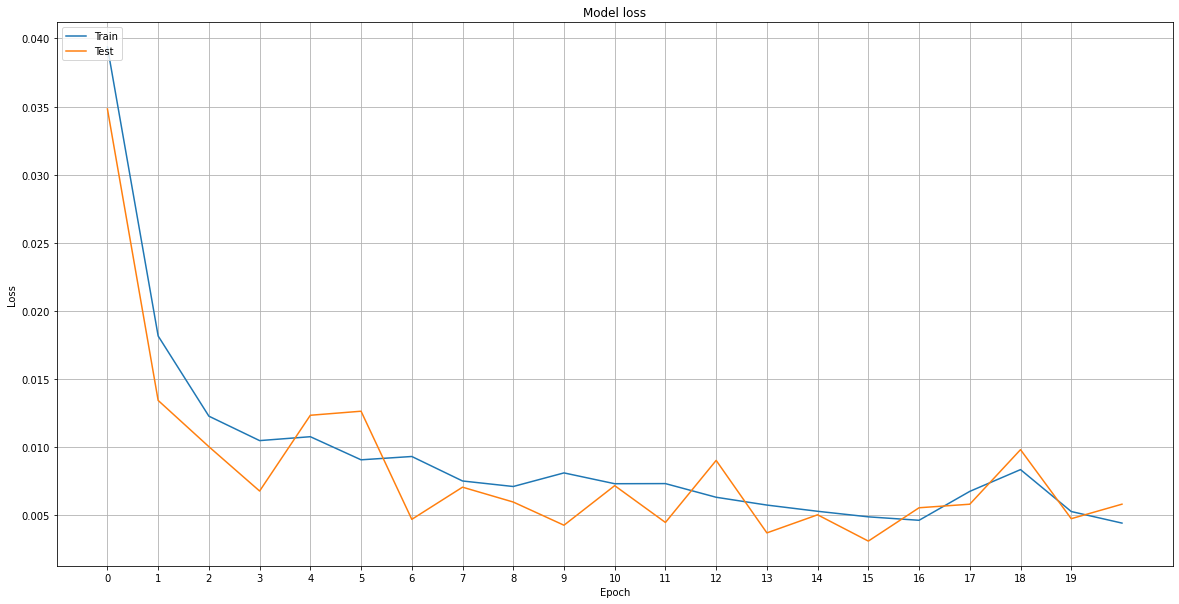

In [21]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"]) 
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(20))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [22]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]

# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)


    # Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_pred = standard_scaler_pred.inverse_transform(y_pred)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))
y_test_unscaled = standard_scaler_pred.inverse_transform(y_test_unscaled)

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])
results

Median Absolute Error (MAE): 0.95
Mean Absolute Percentage Error (MAPE): 4.59 %
Median Absolute Percentage Error (MDAPE): 3.8 %


,MAE,MAPE,MDAPE
0,0.948532,4.585299,3.801455


In [23]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# # Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)
valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

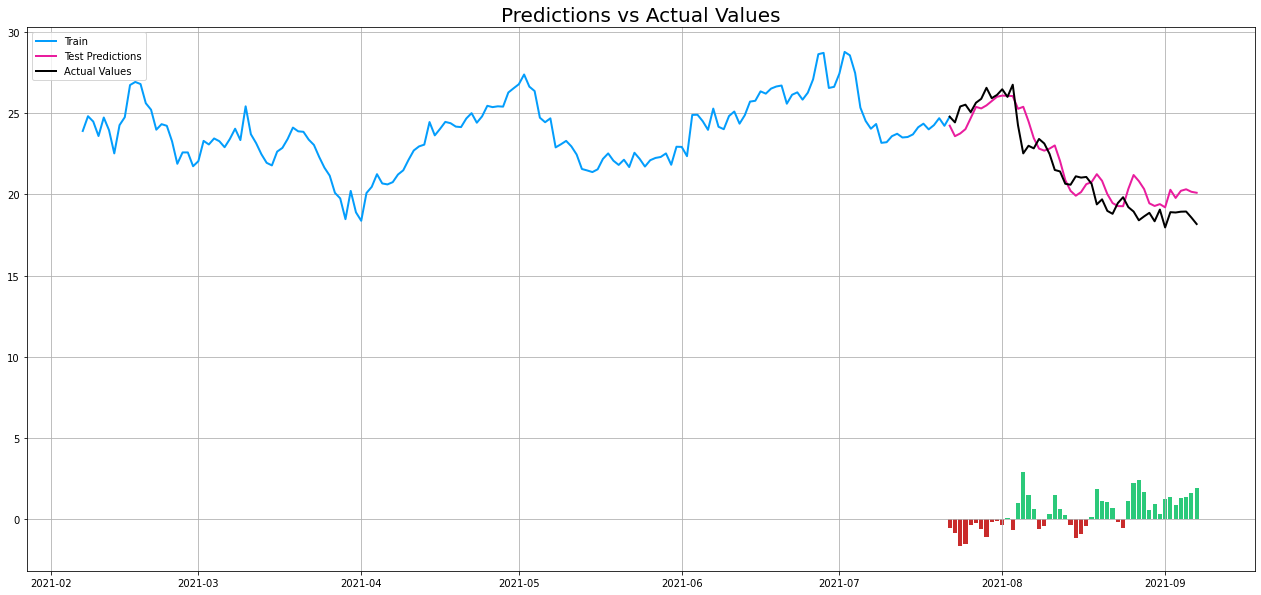

In [24]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

## LSTM: PLTR Daily%Change

### Without Normalization

In [25]:
## DAILY%CHANGE ##
dep_var = ['Daily%Change'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)
pred_lag = pred_lag[['Daily%Change', 'day_of_week','Daily%Change(t-1)','3Dir(t-1)', 'Volume(t-1)', 'Dir(t-1)', 
                     'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)', '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
                     '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)','7Dir(t-1)', '6Dir(t-1)', 
                     '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)', 'Close(t-1)']]
pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['Volume', 'Open', 'Dir', '5Dir', '5D%Change', '6D%Change', '4Dir', '7Dir', '2Dir', '3D%Change', 'SD_log', 'Close', 'Low', 'High', '2D%Change', '6Dir', '4D%Change', 'SD', '7D%Change', '3Dir']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Daily%Change,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,2D%Change(t-1),SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1)
7,-2.597404,2,0.964134,1.0,26887200.0,1.0,26.340000,11.214950,25.510000,11.167733,...,3.888887,0.043892,1.0,4.720001,1.0,1.0,6.422764,1.044869,12.023960,26.180000
8,-2.274510,3,-2.597404,1.0,51216600.0,0.0,25.709999,2.000000,25.129999,9.114245,...,-1.658312,0.516771,1.0,1.190473,1.0,1.0,8.326249,1.676605,3.658535,25.500000
9,2.889243,4,-2.274510,0.0,32908000.0,0.0,25.450001,-1.111114,24.370001,1.300812,...,-4.812835,0.075967,0.0,-3.895103,1.0,1.0,-0.320000,1.078927,5.862358,24.920000
10,3.822159,1,2.889243,0.0,92285500.0,1.0,26.260000,-1.118399,25.459999,8.920979,...,0.549017,1.423364,0.0,-2.062647,1.0,1.0,1.746026,4.151063,2.559998,25.639999
11,-1.051843,2,3.822159,1.0,48675800.0,1.0,26.809999,1.680674,26.000000,6.480003,...,6.821833,0.896991,1.0,4.392160,1.0,1.0,2.661012,2.452214,5.634921,26.620001


In [26]:
# List of considered Features
FEATURES = pred_lag.columns

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Daily%Change']

# Print the tail of the dataframe
data_filtered_ext.tail()

,Daily%Change,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1),Prediction
245,-0.105823,2,5.233856,1.0,33878600.0,1.0,18.160000,0.212084,18.100000,-0.211198,...,0.142083,1.0,3.053432,0.0,1.0,1.394851,1.152673,2.717391,18.900000,-0.105823
246,0.264837,3,-0.105823,0.0,33894200.0,0.0,18.650000,2.944378,18.650000,2.608693,...,-0.584788,1.0,-0.944388,1.0,1.0,0.106037,0.557224,1.287552,18.879999,0.264837
247,0.052827,0,0.264837,1.0,24758300.0,1.0,18.850000,-0.682052,18.719999,1.555799,...,-0.491682,0.0,5.400898,1.0,1.0,3.217013,0.611597,0.371154,18.930000,0.052827
248,-1.953542,1,0.052827,1.0,21782000.0,1.0,18.780001,5.456579,18.780001,0.424178,...,-0.460671,1.0,0.211645,1.0,1.0,-0.629585,0.630860,3.271540,18.940001,-1.953542
249,-2.154010,2,-1.953542,0.0,20518800.0,0.0,18.889999,-1.746031,18.440001,1.254087,...,-0.352068,0.0,-1.641946,1.0,0.0,3.396440,0.703232,-2.570828,18.570000,-2.154010


In [27]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc("Daily%Change")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data
train_data = data_filtered[0:train_data_len]
test_data = data_filtered[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Daily%Change'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(195, 23)
(55, 23)


In [28]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(188, 7, 23) (188,)
(48, 7, 23) (48,)
0.6278450485589007
0.6278450485589007


In [29]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

161 7 23


In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = 'PLTR_woSentiment_DailyChange_woNormalization.h5'
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
12/12 [==============================] - ETA: 0s - loss: 0.0466
Epoch 1: val_loss improved from inf to 0.01381, saving model to PLTR_woSentiment_DailyChange_woNormalization.h5
12/12 [==============================] - 6s 177ms/step - loss: 0.0466 - val_loss: 0.0138
Epoch 2/100
10/12 [========================>.....] - ETA: 0s - loss: 0.0143
Epoch 2: val_loss improved from 0.01381 to 0.00646, saving model to PLTR_woSentiment_DailyChange_woNormalization.h5
12/12 [==============================] - 0s 30ms/step - loss: 0.0150 - val_loss: 0.0065
Epoch 3/100
12/12 [==============================] - ETA: 0s - loss: 0.0129
Epoch 3: val_loss did not improve from 0.00646
12/12 [==============================] - 0s 22ms/step - loss: 0.0129 - val_loss: 0.0072
Epoch 4/100
12/12 [==============================] - ETA: 0s - loss: 0.0124
Epoch 4: val_loss did not improve from 0.00646
12/12 [==============================] - 0s 22ms/step - loss: 0.0124 - val_loss: 0.0067
Epoch 5/100
12/12 [==

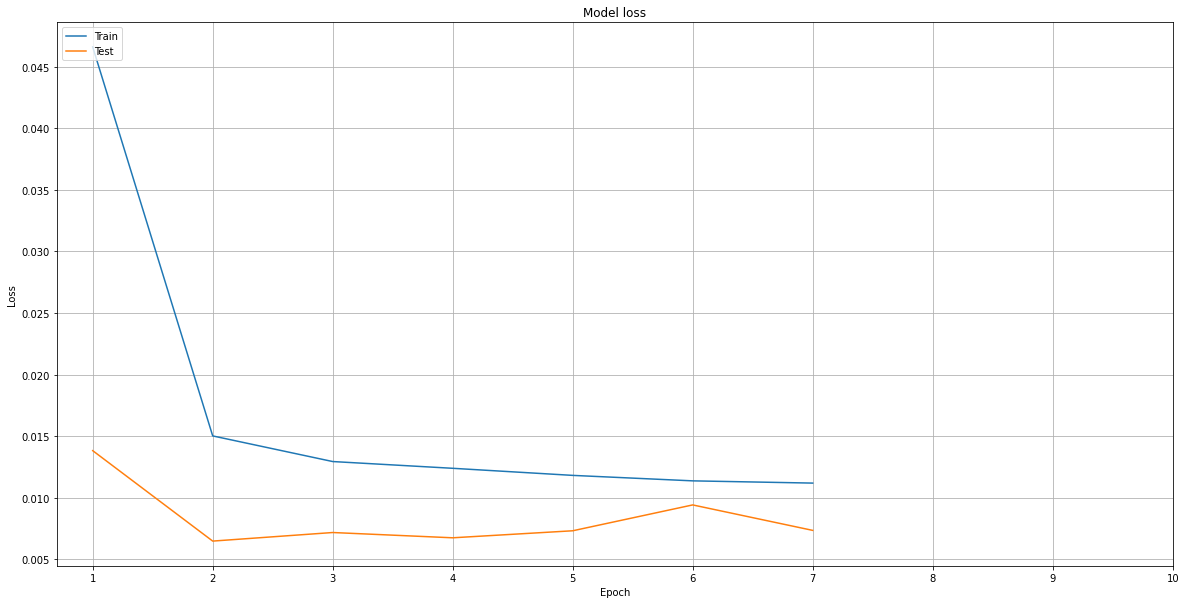

In [31]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [32]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])
results

Median Absolute Error (MAE): 2.45
Mean Absolute Percentage Error (MAPE): 193.42 %
Median Absolute Percentage Error (MDAPE): 121.09 %


,MAE,MAPE,MDAPE
0,2.454315,193.420538,121.093331


In [33]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Daily%Change"], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

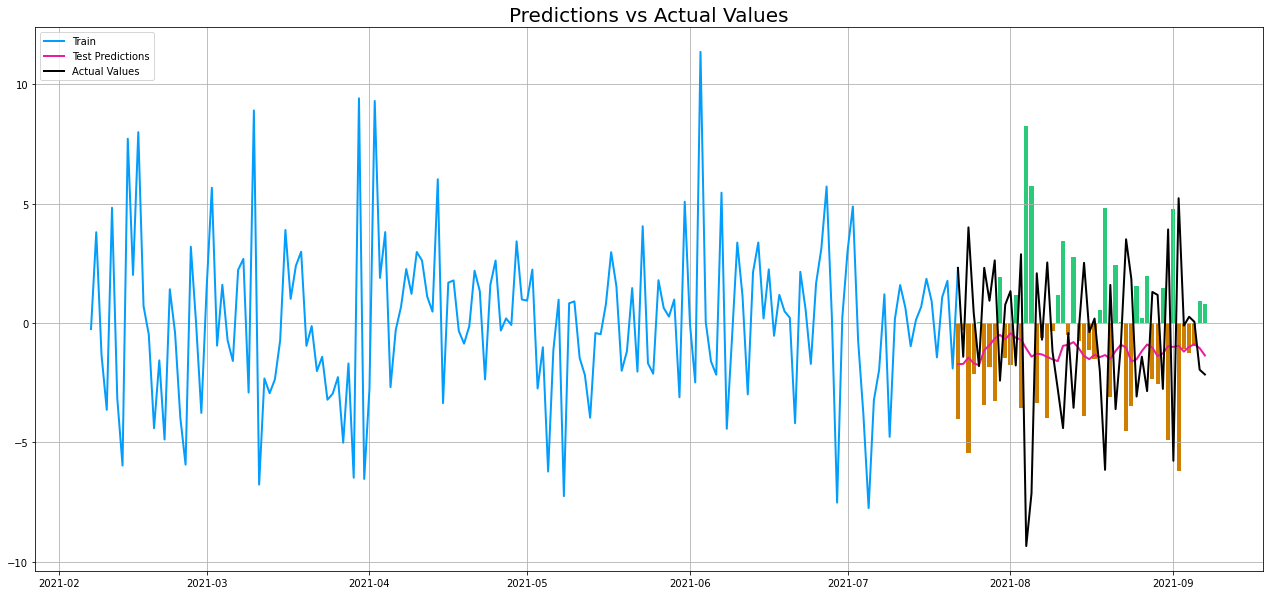

In [34]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Daily%Change"]]
xv = valid['Date']; yv = valid[["Daily%Change", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Daily%Change"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A" #green gain
valid.loc[y < 0, 'diff_color'] = "#ce7e00" #brown loss

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

### Normalization

In [35]:
## DAILY%CHANGE ##
dep_var = ['Daily%Change'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)
pred_lag = pred_lag[['Daily%Change', 'day_of_week','Daily%Change(t-1)','3Dir(t-1)', 'Volume(t-1)', 'Dir(t-1)', 
                     'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)', '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
                     '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)','7Dir(t-1)', '6Dir(t-1)', 
                     '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)', 'Close(t-1)']]
pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['Volume', 'Open', 'Dir', '5Dir', '5D%Change', '6D%Change', '4Dir', '7Dir', '2Dir', '3D%Change', 'SD_log', 'Close', 'Low', 'High', '2D%Change', '6Dir', '4D%Change', 'SD', '7D%Change', '3Dir']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Daily%Change,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,2D%Change(t-1),SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1)
7,-2.597404,2,0.964134,1.0,26887200.0,1.0,26.340000,11.214950,25.510000,11.167733,...,3.888887,0.043892,1.0,4.720001,1.0,1.0,6.422764,1.044869,12.023960,26.180000
8,-2.274510,3,-2.597404,1.0,51216600.0,0.0,25.709999,2.000000,25.129999,9.114245,...,-1.658312,0.516771,1.0,1.190473,1.0,1.0,8.326249,1.676605,3.658535,25.500000
9,2.889243,4,-2.274510,0.0,32908000.0,0.0,25.450001,-1.111114,24.370001,1.300812,...,-4.812835,0.075967,0.0,-3.895103,1.0,1.0,-0.320000,1.078927,5.862358,24.920000
10,3.822159,1,2.889243,0.0,92285500.0,1.0,26.260000,-1.118399,25.459999,8.920979,...,0.549017,1.423364,0.0,-2.062647,1.0,1.0,1.746026,4.151063,2.559998,25.639999
11,-1.051843,2,3.822159,1.0,48675800.0,1.0,26.809999,1.680674,26.000000,6.480003,...,6.821833,0.896991,1.0,4.392160,1.0,1.0,2.661012,2.452214,5.634921,26.620001


In [36]:
# List of considered Features
FEATURES = pred_lag.columns

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Daily%Change']

# Print the tail of the dataframe
data_filtered_ext.tail()

,Daily%Change,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1),Prediction
245,-0.105823,2,5.233856,1.0,33878600.0,1.0,18.160000,0.212084,18.100000,-0.211198,...,0.142083,1.0,3.053432,0.0,1.0,1.394851,1.152673,2.717391,18.900000,-0.105823
246,0.264837,3,-0.105823,0.0,33894200.0,0.0,18.650000,2.944378,18.650000,2.608693,...,-0.584788,1.0,-0.944388,1.0,1.0,0.106037,0.557224,1.287552,18.879999,0.264837
247,0.052827,0,0.264837,1.0,24758300.0,1.0,18.850000,-0.682052,18.719999,1.555799,...,-0.491682,0.0,5.400898,1.0,1.0,3.217013,0.611597,0.371154,18.930000,0.052827
248,-1.953542,1,0.052827,1.0,21782000.0,1.0,18.780001,5.456579,18.780001,0.424178,...,-0.460671,1.0,0.211645,1.0,1.0,-0.629585,0.630860,3.271540,18.940001,-1.953542
249,-2.154010,2,-1.953542,0.0,20518800.0,0.0,18.889999,-1.746031,18.440001,1.254087,...,-0.352068,0.0,-1.641946,1.0,0.0,3.396440,0.703232,-2.570828,18.570000,-2.154010


In [37]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc("Daily%Change")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data
train_data = data_filtered[0:train_data_len]
test_data = data_filtered[train_data_len - sequence_length:]

#first standard scale for continuous variables
to_scale = ['Daily%Change(t-1)', '3Dir(t-1)',
       'Volume(t-1)', 'Dir(t-1)', 'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)',
       '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
       '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)',
       '7Dir(t-1)', '6Dir(t-1)', '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)',
       'Close(t-1)']
standard_scaler = StandardScaler()
train_data[to_scale] = standard_scaler.fit_transform(train_data[to_scale])
test_data[to_scale] = standard_scaler.transform(test_data[to_scale])

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
standard_scaler_pred = StandardScaler()
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Daily%Change'][0:train_data_len])
np_Close_scaled = standard_scaler_pred.fit_transform(df_Close)
np_Close_scaled = scaler_pred.fit_transform(np_Close_scaled)


(195, 23)
(55, 23)


In [38]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(188, 7, 23) (188,)
(48, 7, 23) (48,)
0.6278450485589007
0.6278450485589007


In [39]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

161 7 23


In [40]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = 'PLTR_woSentiment_DailyChange_Normalized.h5'
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
10/12 [========================>.....] - ETA: 0s - loss: 0.0461
Epoch 1: val_loss improved from inf to 0.00999, saving model to PLTR_woSentiment_DailyChange_Normalized.h5
12/12 [==============================] - 10s 222ms/step - loss: 0.0419 - val_loss: 0.0100
Epoch 2/100
10/12 [========================>.....] - ETA: 0s - loss: 0.0176
Epoch 2: val_loss improved from 0.00999 to 0.00897, saving model to PLTR_woSentiment_DailyChange_Normalized.h5
12/12 [==============================] - 0s 27ms/step - loss: 0.0164 - val_loss: 0.0090
Epoch 3/100
10/12 [========================>.....] - ETA: 0s - loss: 0.0114
Epoch 3: val_loss improved from 0.00897 to 0.00729, saving model to PLTR_woSentiment_DailyChange_Normalized.h5
12/12 [==============================] - 0s 28ms/step - loss: 0.0123 - val_loss: 0.0073
Epoch 4/100
 9/12 [=====================>........] - ETA: 0s - loss: 0.0116
Epoch 4: val_loss improved from 0.00729 to 0.00679, saving model to PLTR_woSentiment_DailyChange_Norm

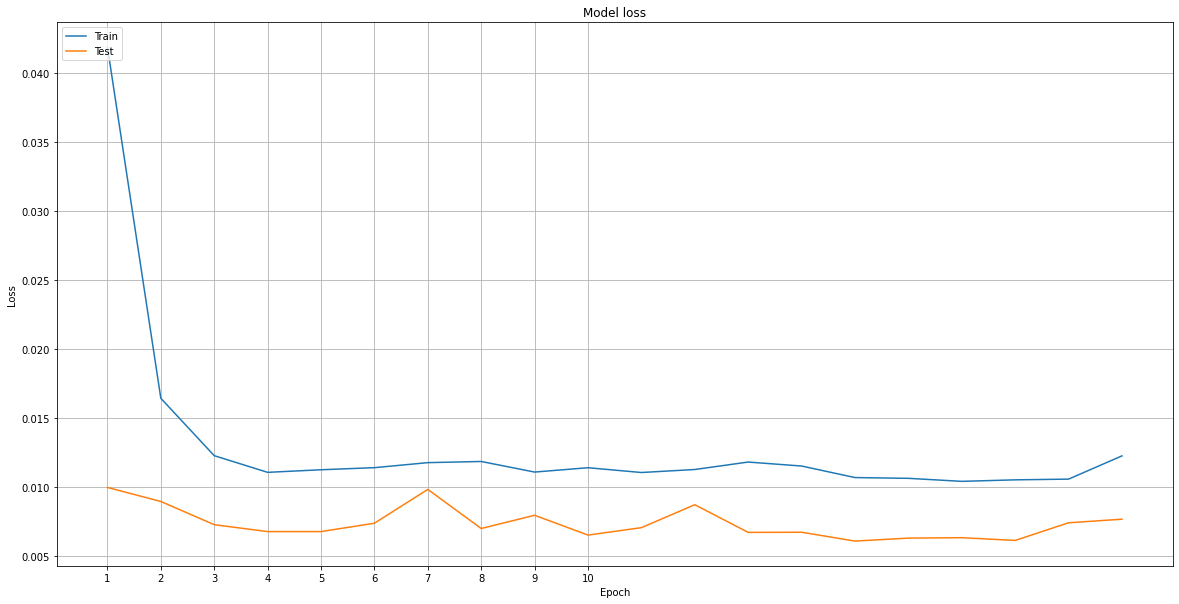

In [41]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [42]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_pred = standard_scaler_pred.inverse_transform(y_pred)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))
y_test_unscaled = standard_scaler_pred.inverse_transform(y_test_unscaled)

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])
results

Median Absolute Error (MAE): 2.37
Mean Absolute Percentage Error (MAPE): 110.61 %
Median Absolute Percentage Error (MDAPE): 98.13 %


,MAE,MAPE,MDAPE
0,2.368068,110.607744,98.128009


In [43]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Daily%Change"], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

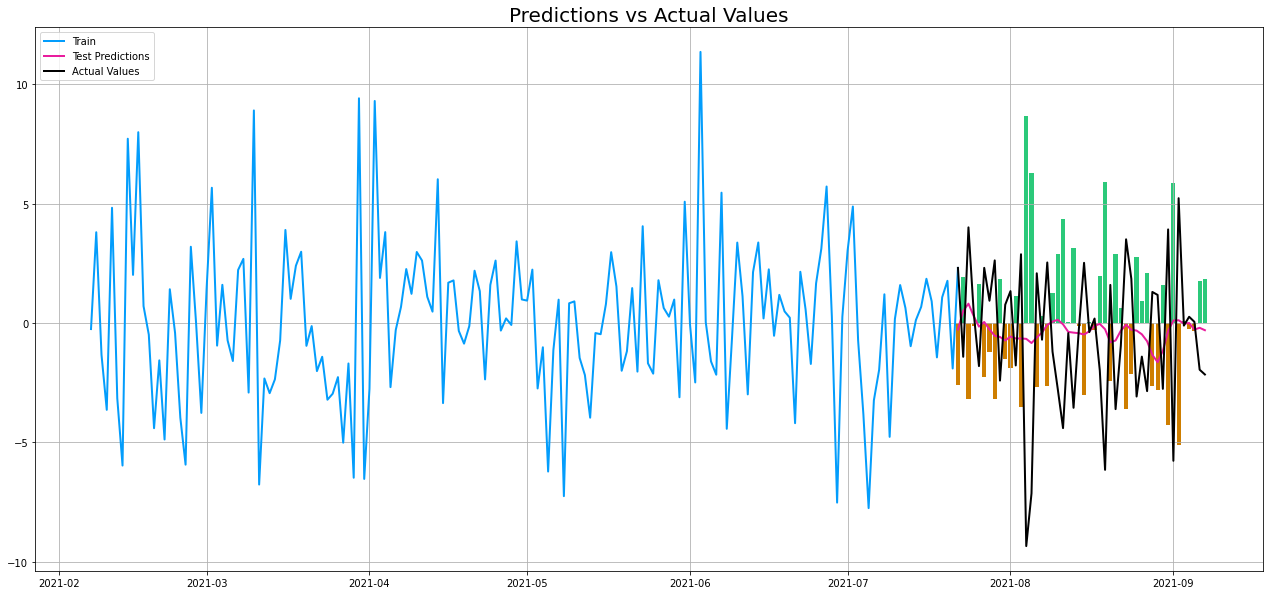

In [44]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Daily%Change"]]
xv = valid['Date']; yv = valid[["Daily%Change", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Daily%Change"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A" #green gain
valid.loc[y < 0, 'diff_color'] = "#ce7e00" #brown loss

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

## LSTM: PLTR SD

### Without Normalization

In [45]:
## DAILY%CHANGE ##
dep_var = ['SD'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)
pred_lag = pred_lag[['SD', 'day_of_week','Daily%Change(t-1)','3Dir(t-1)', 'Volume(t-1)', 'Dir(t-1)', 
                     'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)', '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
                     '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)','7Dir(t-1)', '6Dir(t-1)', 
                     '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)', 'Close(t-1)']]
pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['Volume', 'Open', 'Dir', '5Dir', '5D%Change', '6D%Change', '4Dir', '7Dir', '2Dir', '3D%Change', 'SD_log', 'Close', 'Low', 'High', '2D%Change', '6Dir', '4D%Change', 'Daily%Change', '7D%Change', '3Dir']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,SD,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,2D%Change(t-1),SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1)
7,1.676605,2,0.964134,1.0,26887200.0,1.0,26.340000,11.214950,25.510000,11.167733,...,3.888887,0.043892,1.0,4.720001,1.0,1.0,6.422764,1.044869,12.023960,26.180000
8,1.078927,3,-2.597404,1.0,51216600.0,0.0,25.709999,2.000000,25.129999,9.114245,...,-1.658312,0.516771,1.0,1.190473,1.0,1.0,8.326249,1.676605,3.658535,25.500000
9,4.151063,4,-2.274510,0.0,32908000.0,0.0,25.450001,-1.111114,24.370001,1.300812,...,-4.812835,0.075967,0.0,-3.895103,1.0,1.0,-0.320000,1.078927,5.862358,24.920000
10,2.452214,1,2.889243,0.0,92285500.0,1.0,26.260000,-1.118399,25.459999,8.920979,...,0.549017,1.423364,0.0,-2.062647,1.0,1.0,1.746026,4.151063,2.559998,25.639999
11,1.089413,2,3.822159,1.0,48675800.0,1.0,26.809999,1.680674,26.000000,6.480003,...,6.821833,0.896991,1.0,4.392160,1.0,1.0,2.661012,2.452214,5.634921,26.620001


In [46]:
# List of considered Features
FEATURES = pred_lag.columns

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['SD']

# Print the tail of the dataframe
data_filtered_ext.tail()

,SD,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1),Prediction
245,0.557224,2,5.233856,1.0,33878600.0,1.0,18.160000,0.212084,18.100000,-0.211198,...,0.142083,1.0,3.053432,0.0,1.0,1.394851,1.152673,2.717391,18.900000,0.557224
246,0.611597,3,-0.105823,0.0,33894200.0,0.0,18.650000,2.944378,18.650000,2.608693,...,-0.584788,1.0,-0.944388,1.0,1.0,0.106037,0.557224,1.287552,18.879999,0.611597
247,0.630860,0,0.264837,1.0,24758300.0,1.0,18.850000,-0.682052,18.719999,1.555799,...,-0.491682,0.0,5.400898,1.0,1.0,3.217013,0.611597,0.371154,18.930000,0.630860
248,0.703232,1,0.052827,1.0,21782000.0,1.0,18.780001,5.456579,18.780001,0.424178,...,-0.460671,1.0,0.211645,1.0,1.0,-0.629585,0.630860,3.271540,18.940001,0.703232
249,1.297171,2,-1.953542,0.0,20518800.0,0.0,18.889999,-1.746031,18.440001,1.254087,...,-0.352068,0.0,-1.641946,1.0,0.0,3.396440,0.703232,-2.570828,18.570000,1.297171


In [47]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc("SD")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data
train_data = data_filtered[0:train_data_len]
test_data = data_filtered[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['SD'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(195, 23)
(55, 23)


In [48]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(188, 7, 23) (188,)
(48, 7, 23) (48,)
0.7533632261350673
0.7533632261350673


In [49]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

161 7 23


In [50]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = 'PLTR_woSentiment_SD_woNormalization.h5'
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0487
Epoch 1: val_loss improved from inf to 0.01945, saving model to PLTR_woSentiment_SD_woNormalization.h5
12/12 [==============================] - 5s 100ms/step - loss: 0.0471 - val_loss: 0.0194
Epoch 2/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0203
Epoch 2: val_loss improved from 0.01945 to 0.00643, saving model to PLTR_woSentiment_SD_woNormalization.h5
12/12 [==============================] - 0s 18ms/step - loss: 0.0240 - val_loss: 0.0064
Epoch 3/100
12/12 [==============================] - ETA: 0s - loss: 0.0189
Epoch 3: val_loss did not improve from 0.00643
12/12 [==============================] - 0s 21ms/step - loss: 0.0189 - val_loss: 0.0074
Epoch 4/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0163
Epoch 4: val_loss did not improve from 0.00643
12/12 [==============================] - 0s 26ms/step - loss: 0.0156 - val_loss: 0.0073
Epoch 5/100
11/12 [====================

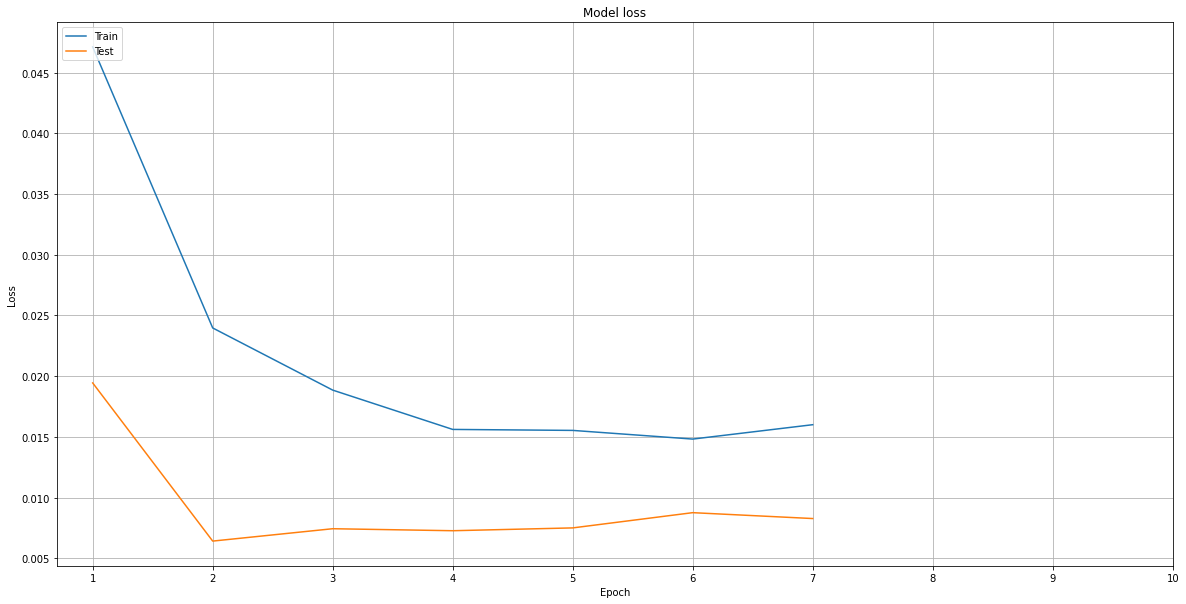

In [51]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [52]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])
results

Median Absolute Error (MAE): 0.45
Mean Absolute Percentage Error (MAPE): 44.63 %
Median Absolute Percentage Error (MDAPE): 41.64 %


,MAE,MAPE,MDAPE
0,0.449457,44.62927,41.64321


In [53]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["SD"], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

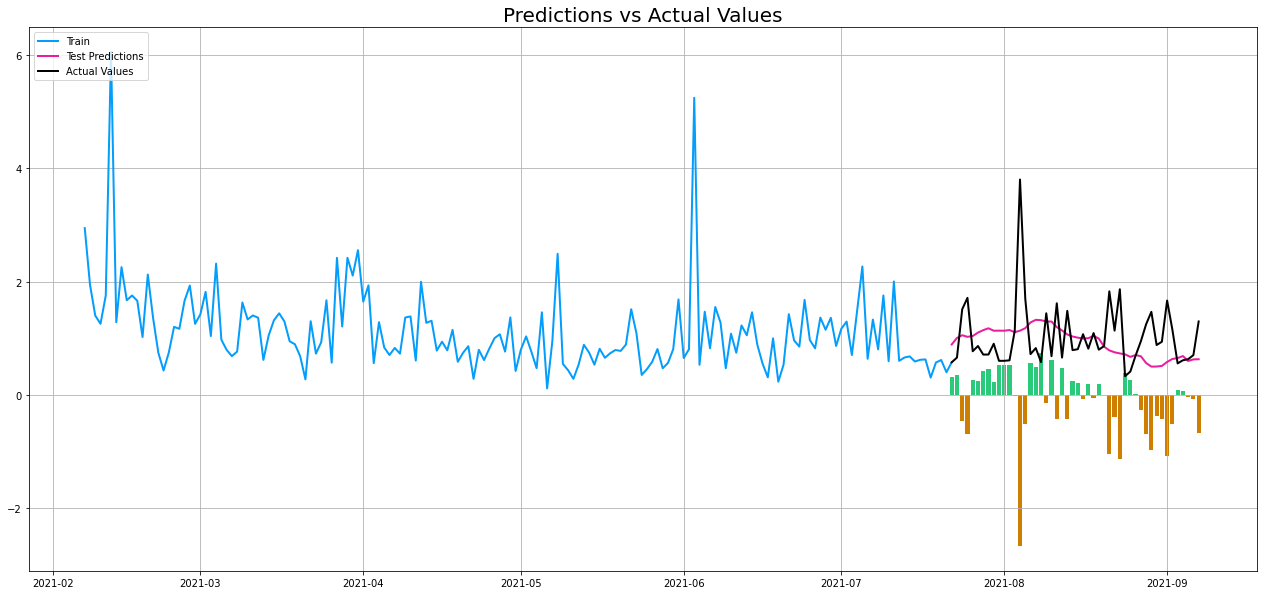

In [54]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["SD"]]
xv = valid['Date']; yv = valid[["SD", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["SD"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A" #green gain
valid.loc[y < 0, 'diff_color'] = "#ce7e00" #brown loss

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

### Normalization

In [55]:
## DAILY%CHANGE ##
dep_var = ['SD'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)
pred_lag = pred_lag[['SD', 'day_of_week','Daily%Change(t-1)','3Dir(t-1)', 'Volume(t-1)', 'Dir(t-1)', 
                     'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)', '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
                     '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)','7Dir(t-1)', '6Dir(t-1)', 
                     '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)', 'Close(t-1)']]
pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['Volume', 'Open', 'Dir', '5Dir', '5D%Change', '6D%Change', '4Dir', '7Dir', '2Dir', '3D%Change', 'SD_log', 'Close', 'Low', 'High', '2D%Change', '6Dir', '4D%Change', 'Daily%Change', '7D%Change', '3Dir']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,SD,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,2D%Change(t-1),SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1)
7,1.676605,2,0.964134,1.0,26887200.0,1.0,26.340000,11.214950,25.510000,11.167733,...,3.888887,0.043892,1.0,4.720001,1.0,1.0,6.422764,1.044869,12.023960,26.180000
8,1.078927,3,-2.597404,1.0,51216600.0,0.0,25.709999,2.000000,25.129999,9.114245,...,-1.658312,0.516771,1.0,1.190473,1.0,1.0,8.326249,1.676605,3.658535,25.500000
9,4.151063,4,-2.274510,0.0,32908000.0,0.0,25.450001,-1.111114,24.370001,1.300812,...,-4.812835,0.075967,0.0,-3.895103,1.0,1.0,-0.320000,1.078927,5.862358,24.920000
10,2.452214,1,2.889243,0.0,92285500.0,1.0,26.260000,-1.118399,25.459999,8.920979,...,0.549017,1.423364,0.0,-2.062647,1.0,1.0,1.746026,4.151063,2.559998,25.639999
11,1.089413,2,3.822159,1.0,48675800.0,1.0,26.809999,1.680674,26.000000,6.480003,...,6.821833,0.896991,1.0,4.392160,1.0,1.0,2.661012,2.452214,5.634921,26.620001


In [56]:
# List of considered Features
FEATURES = pred_lag.columns

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['SD']

# Print the tail of the dataframe
data_filtered_ext.tail()

,SD,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1),Prediction
245,0.557224,2,5.233856,1.0,33878600.0,1.0,18.160000,0.212084,18.100000,-0.211198,...,0.142083,1.0,3.053432,0.0,1.0,1.394851,1.152673,2.717391,18.900000,0.557224
246,0.611597,3,-0.105823,0.0,33894200.0,0.0,18.650000,2.944378,18.650000,2.608693,...,-0.584788,1.0,-0.944388,1.0,1.0,0.106037,0.557224,1.287552,18.879999,0.611597
247,0.630860,0,0.264837,1.0,24758300.0,1.0,18.850000,-0.682052,18.719999,1.555799,...,-0.491682,0.0,5.400898,1.0,1.0,3.217013,0.611597,0.371154,18.930000,0.630860
248,0.703232,1,0.052827,1.0,21782000.0,1.0,18.780001,5.456579,18.780001,0.424178,...,-0.460671,1.0,0.211645,1.0,1.0,-0.629585,0.630860,3.271540,18.940001,0.703232
249,1.297171,2,-1.953542,0.0,20518800.0,0.0,18.889999,-1.746031,18.440001,1.254087,...,-0.352068,0.0,-1.641946,1.0,0.0,3.396440,0.703232,-2.570828,18.570000,1.297171


In [57]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc("SD")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data
train_data = data_filtered[0:train_data_len]
test_data = data_filtered[train_data_len - sequence_length:]

#first standard scale for continuous variables
to_scale = ['Daily%Change(t-1)', '3Dir(t-1)',
       'Volume(t-1)', 'Dir(t-1)', 'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)',
       '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
       '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)',
       '7Dir(t-1)', '6Dir(t-1)', '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)',
       'Close(t-1)']
standard_scaler = StandardScaler()
train_data[to_scale] = standard_scaler.fit_transform(train_data[to_scale])
test_data[to_scale] = standard_scaler.transform(test_data[to_scale])

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
standard_scaler_pred = StandardScaler()
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['SD'][0:train_data_len])
np_Close_scaled = standard_scaler_pred.fit_transform(df_Close)
np_Close_scaled = scaler_pred.fit_transform(np_Close_scaled)


(195, 23)
(55, 23)


In [58]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(188, 7, 23) (188,)
(48, 7, 23) (48,)
0.7533632261350673
0.7533632261350673


In [59]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

161 7 23


In [60]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = 'PLTR_woSentiment_SD_Normalized.h5'
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
 9/12 [=====================>........] - ETA: 0s - loss: 0.0642 
Epoch 1: val_loss improved from inf to 0.01562, saving model to PLTR_woSentiment_SD_Normalized.h5
12/12 [==============================] - 9s 112ms/step - loss: 0.0519 - val_loss: 0.0156
Epoch 2/100
10/12 [========================>.....] - ETA: 0s - loss: 0.0201
Epoch 2: val_loss improved from 0.01562 to 0.00661, saving model to PLTR_woSentiment_SD_Normalized.h5
12/12 [==============================] - 0s 20ms/step - loss: 0.0196 - val_loss: 0.0066
Epoch 3/100
 9/12 [=====================>........] - ETA: 0s - loss: 0.0188
Epoch 3: val_loss did not improve from 0.00661
12/12 [==============================] - 0s 17ms/step - loss: 0.0170 - val_loss: 0.0073
Epoch 4/100
 9/12 [=====================>........] - ETA: 0s - loss: 0.0175
Epoch 4: val_loss did not improve from 0.00661
12/12 [==============================] - 0s 21ms/step - loss: 0.0167 - val_loss: 0.0088
Epoch 5/100
 9/12 [=====================>.......

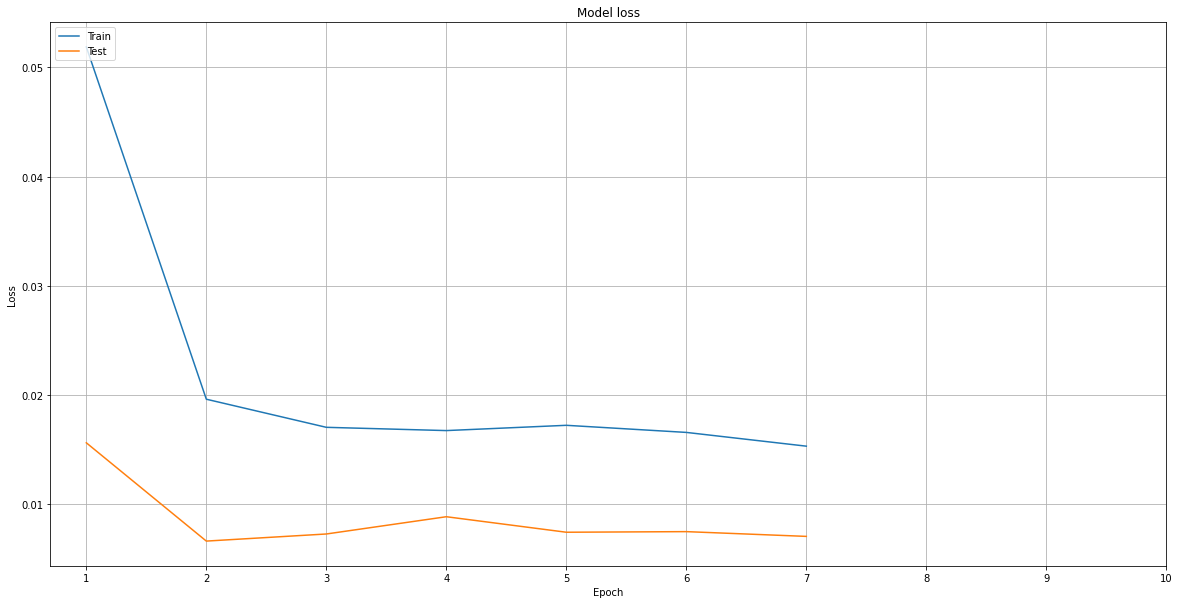

In [61]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [62]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_pred = standard_scaler_pred.inverse_transform(y_pred)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))
y_test_unscaled = standard_scaler_pred.inverse_transform(y_test_unscaled)

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])
results

Median Absolute Error (MAE): 0.46
Mean Absolute Percentage Error (MAPE): 53.37 %
Median Absolute Percentage Error (MDAPE): 46.22 %


,MAE,MAPE,MDAPE
0,0.464233,53.371037,46.217139


In [63]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["SD"], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

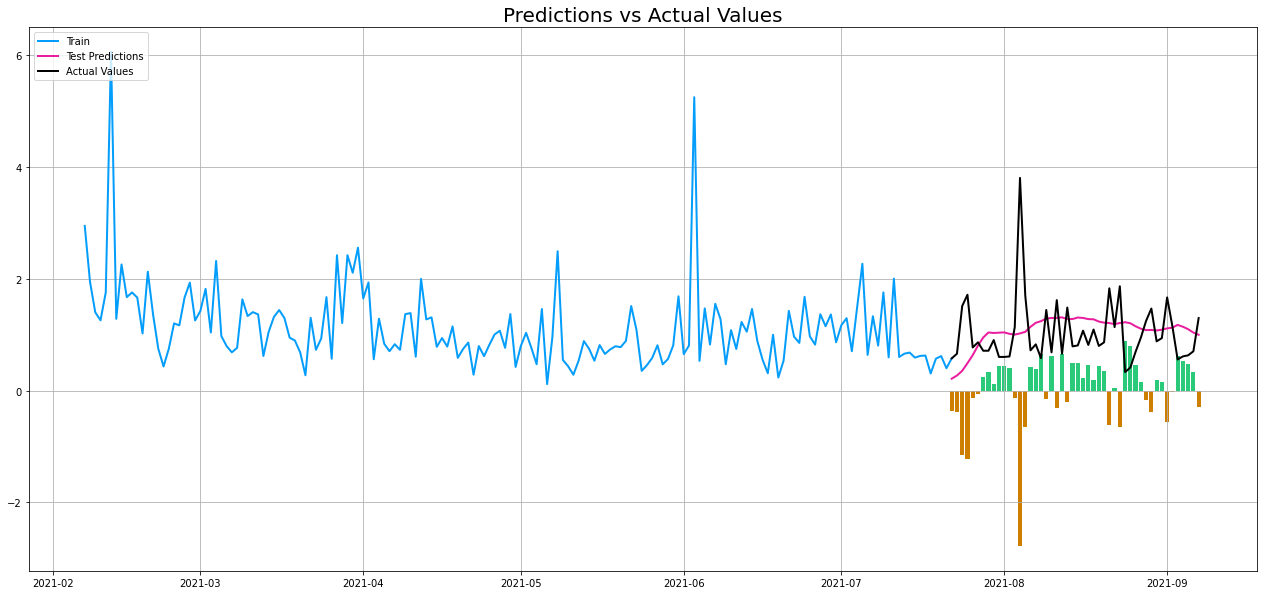

In [64]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["SD"]]
xv = valid['Date']; yv = valid[["SD", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["SD"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A" #green gain
valid.loc[y < 0, 'diff_color'] = "#ce7e00" #brown loss

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()